# Imports and file loading

In [48]:
import sys
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/lib/oi/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/lib/rp/')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.animation as animation
%matplotlib inline
from scipy.ndimage.interpolation import rotate
from math import cos, sin
import time
import random
import string
import optical_imaging as oi
import copy
import oi_file
from scipy.ndimage.filters import gaussian_filter
import resistive_pulse as rp
import os
pi=3.14159
import cv2

In [49]:
file_directory = '/home/prestonh/Desktop/Research/cancer_cells/data/3-1-2017/17p5_30_17p5_0/oi/bin/'
#file_directory = '/home/prestonh/Desktop/Research/cancer_cells/data/2-24-2017/17p5_30_17p5_4/oi/bin/'
file_name = 'test_camera_3'
file_path = file_directory + file_name
output_file_path = file_path + '_events.json'
vid = oi_file.Raw(file_path, 512, 288, 50000, 5)
#vid = oi_file.Raw(file_path, 640, 480, 50000, 5)

# Define template image and stage

- 'first_cell_imaging':
    - c0: 210, 145
    - c1: 207, 129
    - c2: 298, 125
    - c3: 300, 140
    
- 7-4-2016
    - mix_0001
        - c0: 426, 233
        - c1: 426, 217
        - c2: 517, 217
        - c3: 517, 233
        
- 7-10-2016
    - HCT_0000
        - c0:
        - c1:
        - c2:
        - c3:

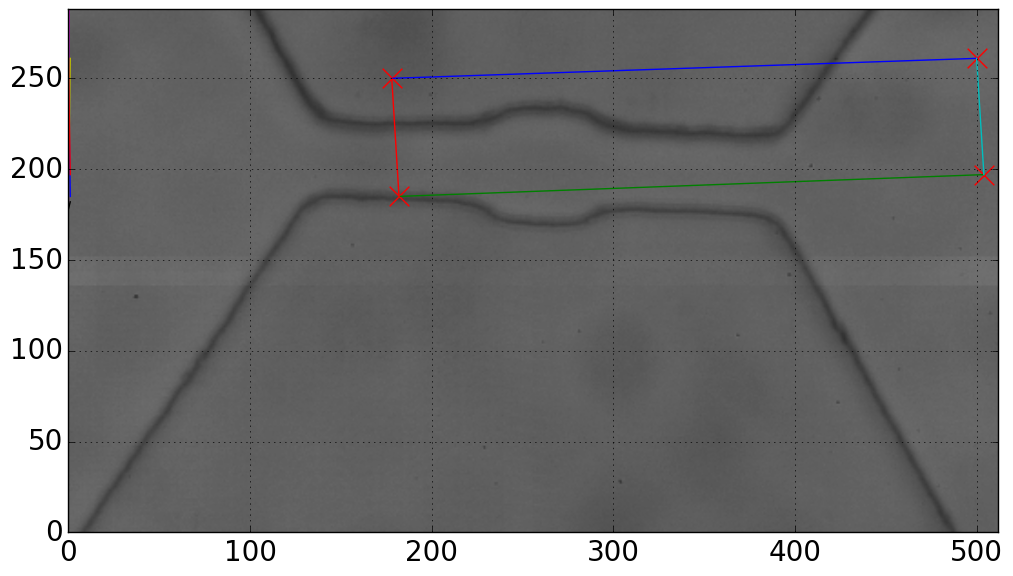

In [50]:
template_frame = vid.get_frame(0)

c0 = np.array([178,250])
c1 = np.array([182,185])
c2 = np.array([500,261])
c3 = np.array([504,197])

c = np.array([c0, c1, c2, c3])
stage = oi.Stage(template_frame, c0, c1, c2, c3)

fig = plt.figure(figsize = (12,9))

plt.imshow(template_frame, cmap = 'gray', vmin = 0, vmax = 1, origin = 'lower')

plt.scatter(c[:,0], c[:,1], marker = 'x', s = 200, c = 'red')
plt.plot([c0[0], c2[0]], [c0[1], c2[1]])
plt.plot([c1[0], c3[0]], [c1[1], c3[1]])
plt.plot([c0[0], c1[0]], [c0[1], c1[1]])
plt.plot([c2[0], c3[0]], [c2[1], c3[1]])
plt.plot([c1, c2])
plt.plot([c0, c1])
plt.plot([c2, c3])

plt.grid()

plt.tick_params(labelsize = 20)

plt.xlim(0, vid._image_width)
plt.ylim(0, vid._image_height)

plt.show()

# Optimize alpha, beta

### Get frame with cluster

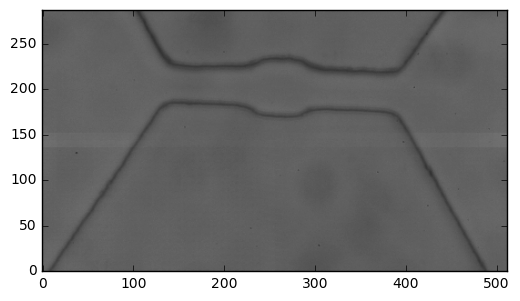

In [51]:
template_index = 0
template_frame = vid.get_frame(template_index)
plt.imshow(template_frame, cmap = 'gray', origin = 'lower', vmin = 0, vmax = 1)
plt.show()

In [52]:
template_index = 0
template_frame = vid.get_frame(template_index)

threshold_difference = 0.03

print vid._total_frames

num_found = 0
for i in range(10500, vid._total_frames):
    if i%1000 == 0:
        print i
    frame = vid.get_frame(i)
    clusters = oi.find_clusters_percentage_based(frame, template_frame, threshold_difference = threshold_difference)
    if(len(clusters)) > 0:
        print i
        num_found+=1
        if num_found > 5:
            #break
            pass
            

49974
11000
11311
11312
11313
11314
11315
11316
11317
11318
11319
11320
11321
11322
11323
11324
11325
11326
11327
11328
11329
11330
11331
11332
11333
11334
11335
11336
11337
11338


KeyboardInterrupt: 

### Show image, template image, difference

1


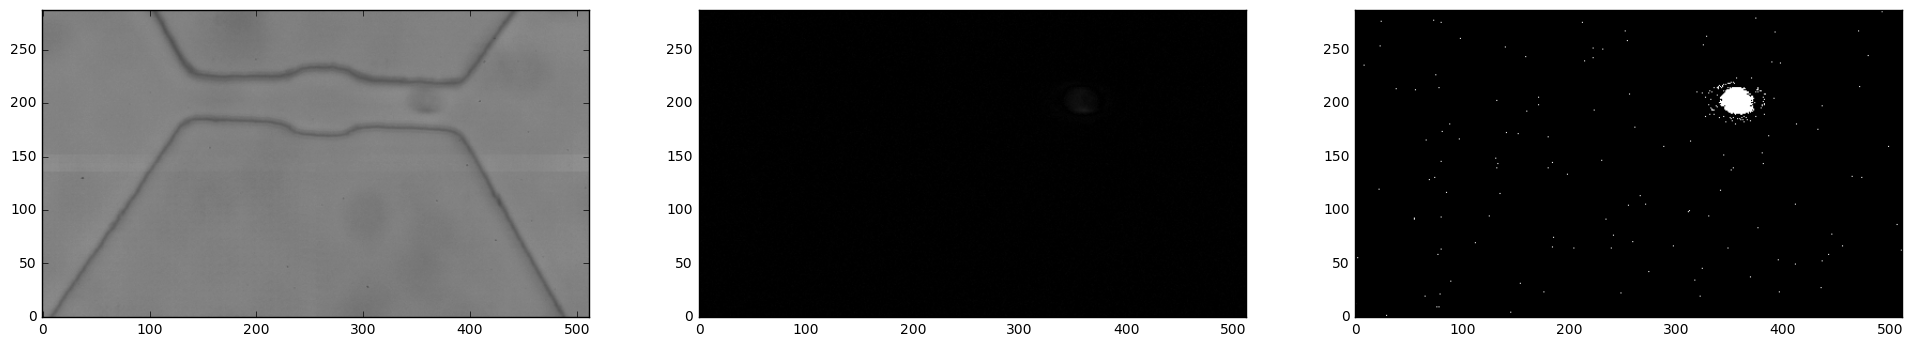

In [58]:
reload(oi)
index = 11335

template_frame = vid.get_frame(template_index)
frame = vid.get_frame(index)

threshold_difference = .02

alpha = 1
beta = 'avg'    # -(np.mean(frame)-.5)
template_frame = oi.change_frame_contrast(template_frame, alpha = alpha, beta = beta)
frame = oi.change_frame_contrast(frame, alpha = alpha, beta = beta)


cluster_threshold = 100


neg_frame = abs(frame - template_frame)
clusters = oi.find_clusters_percentage_based(frame, template_frame, threshold_difference = threshold_difference,\
                                             cluster_threshold = cluster_threshold)
temp_neg_frame = copy.deepcopy(neg_frame[:,:])
temp_neg_frame[temp_neg_frame > threshold_difference] = 1
temp_neg_frame[temp_neg_frame <= threshold_difference] = 0

print len(clusters)
fig, axes = plt.subplots(1,3,figsize=(24,8))

# Raw image
plt.sca(axes[0])
plt.imshow(frame, cmap = 'gray', vmin = 0, vmax = 1, origin = 'lower')

# Negative
plt.sca(axes[1])
plt.imshow(neg_frame, cmap = 'gray', vmin = 0, vmax = 1, origin = 'lower')

# Thresholded negative
plt.sca(axes[2])
plt.imshow(temp_neg_frame, vmin = 0, vmax = 1, cmap = 'gray', origin = 'lower')

plt.show()

# Find events

### Replace pixels in template frame if it has a particle in it

In [6]:
"""
rep_value_0 = .468431
rep_value_1 = .478431
rep_value_2 = .471431
rep_value_3 = .461431
#temp_template_frame = copy.copy(template_frame)
#temp_template_frame[310-10:310+10,148-10:148+10] = rep_value_0
#temp_template_frame[270-10:270+10,431-10:431+10] = rep_value_1
#temp_template_frame[281-10:281+10,510-10:510+10] = rep_value_2
#temp_template_frame[158-10:158+10,491-10:491+10] = rep_value_2
#temp_template_frame[70-10:70+10,548-10:548+10] = rep_value_3

fig = plt.figure(figsize = (16,12))
plt.imshow(template_frame,  cmap = 'gray', vmin = 0, vmax = 1, origin = 'lower')
plt.show()
"""

"\nrep_value_0 = .468431\nrep_value_1 = .478431\nrep_value_2 = .471431\nrep_value_3 = .461431\n#temp_template_frame = copy.copy(template_frame)\n#temp_template_frame[310-10:310+10,148-10:148+10] = rep_value_0\n#temp_template_frame[270-10:270+10,431-10:431+10] = rep_value_1\n#temp_template_frame[281-10:281+10,510-10:510+10] = rep_value_2\n#temp_template_frame[158-10:158+10,491-10:491+10] = rep_value_2\n#temp_template_frame[70-10:70+10,548-10:548+10] = rep_value_3\n\nfig = plt.figure(figsize = (16,12))\nplt.imshow(template_frame,  cmap = 'gray', vmin = 0, vmax = 1, origin = 'lower')\nplt.show()\n"

### Find the events

In [59]:
reload(oi)
alpha = 1
beta = 'avg'
raw_events = oi.find_events(vid, ti = 0, threshold_difference = threshold_difference, cluster_threshold = cluster_threshold, alpha = alpha, beta = 'avg')

t:  0 / 49974 	clusters: 0 	active: 0 	inactive: 0
t:  1000 / 49974 	clusters: 0 	active: 0 	inactive: 0
t:  2000 / 49974 	clusters: 0 	active: 0 	inactive: 1
t:  3000 / 49974 	clusters: 0 	active: 0 	inactive: 2
t:  4000 / 49974 	clusters: 0 	active: 0 	inactive: 10
t:  5000 / 49974 	clusters: 0 	active: 0 	inactive: 11
t:  6000 / 49974 	clusters: 0 	active: 0 	inactive: 22
t:  7000 / 49974 	clusters: 1 	active: 1 	inactive: 34
t:  8000 / 49974 	clusters: 0 	active: 0 	inactive: 49
t:  9000 / 49974 	clusters: 1 	active: 1 	inactive: 66
t:  10000 / 49974 	clusters: 0 	active: 0 	inactive: 72
t:  11000 / 49974 	clusters: 0 	active: 0 	inactive: 72
t:  12000 / 49974 	clusters: 0 	active: 0 	inactive: 73
t:  13000 / 49974 	clusters: 0 	active: 0 	inactive: 77
t:  14000 / 49974 	clusters: 0 	active: 0 	inactive: 78
t:  15000 / 49974 	clusters: 0 	active: 0 	inactive: 85
t:  16000 / 49974 	clusters: 0 	active: 0 	inactive: 86
t:  17000 / 49974 	clusters: 0 	active: 0 	inactive: 86
t:  18000

### Inspection

In [60]:
events = raw_events[:]

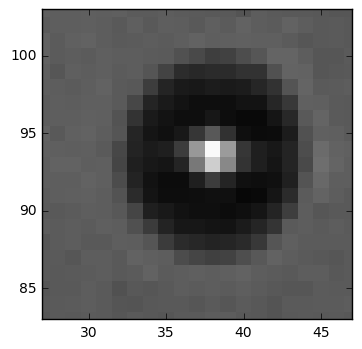

In [29]:
det = raw_events[0]._detections[500]

plt.imshow(vid.get_frame(det._tf), cmap = 'gray', origin = 'lower', interpolation = 'none')

plt.xlim(det._px-10, det._px+10)
plt.ylim(det._py-10, det._py+10)


plt.show()

In [35]:
for event in raw_events:
    print event._detections[0]._tf/50000.

0.11408
0.29954
0.4826
0.55568
0.60156
0.89064


In [129]:
cutoff = 100
events = [raw_event for raw_event in raw_events if len(raw_event._detections) > cutoff]
print len(raw_events), len(events)

793 94


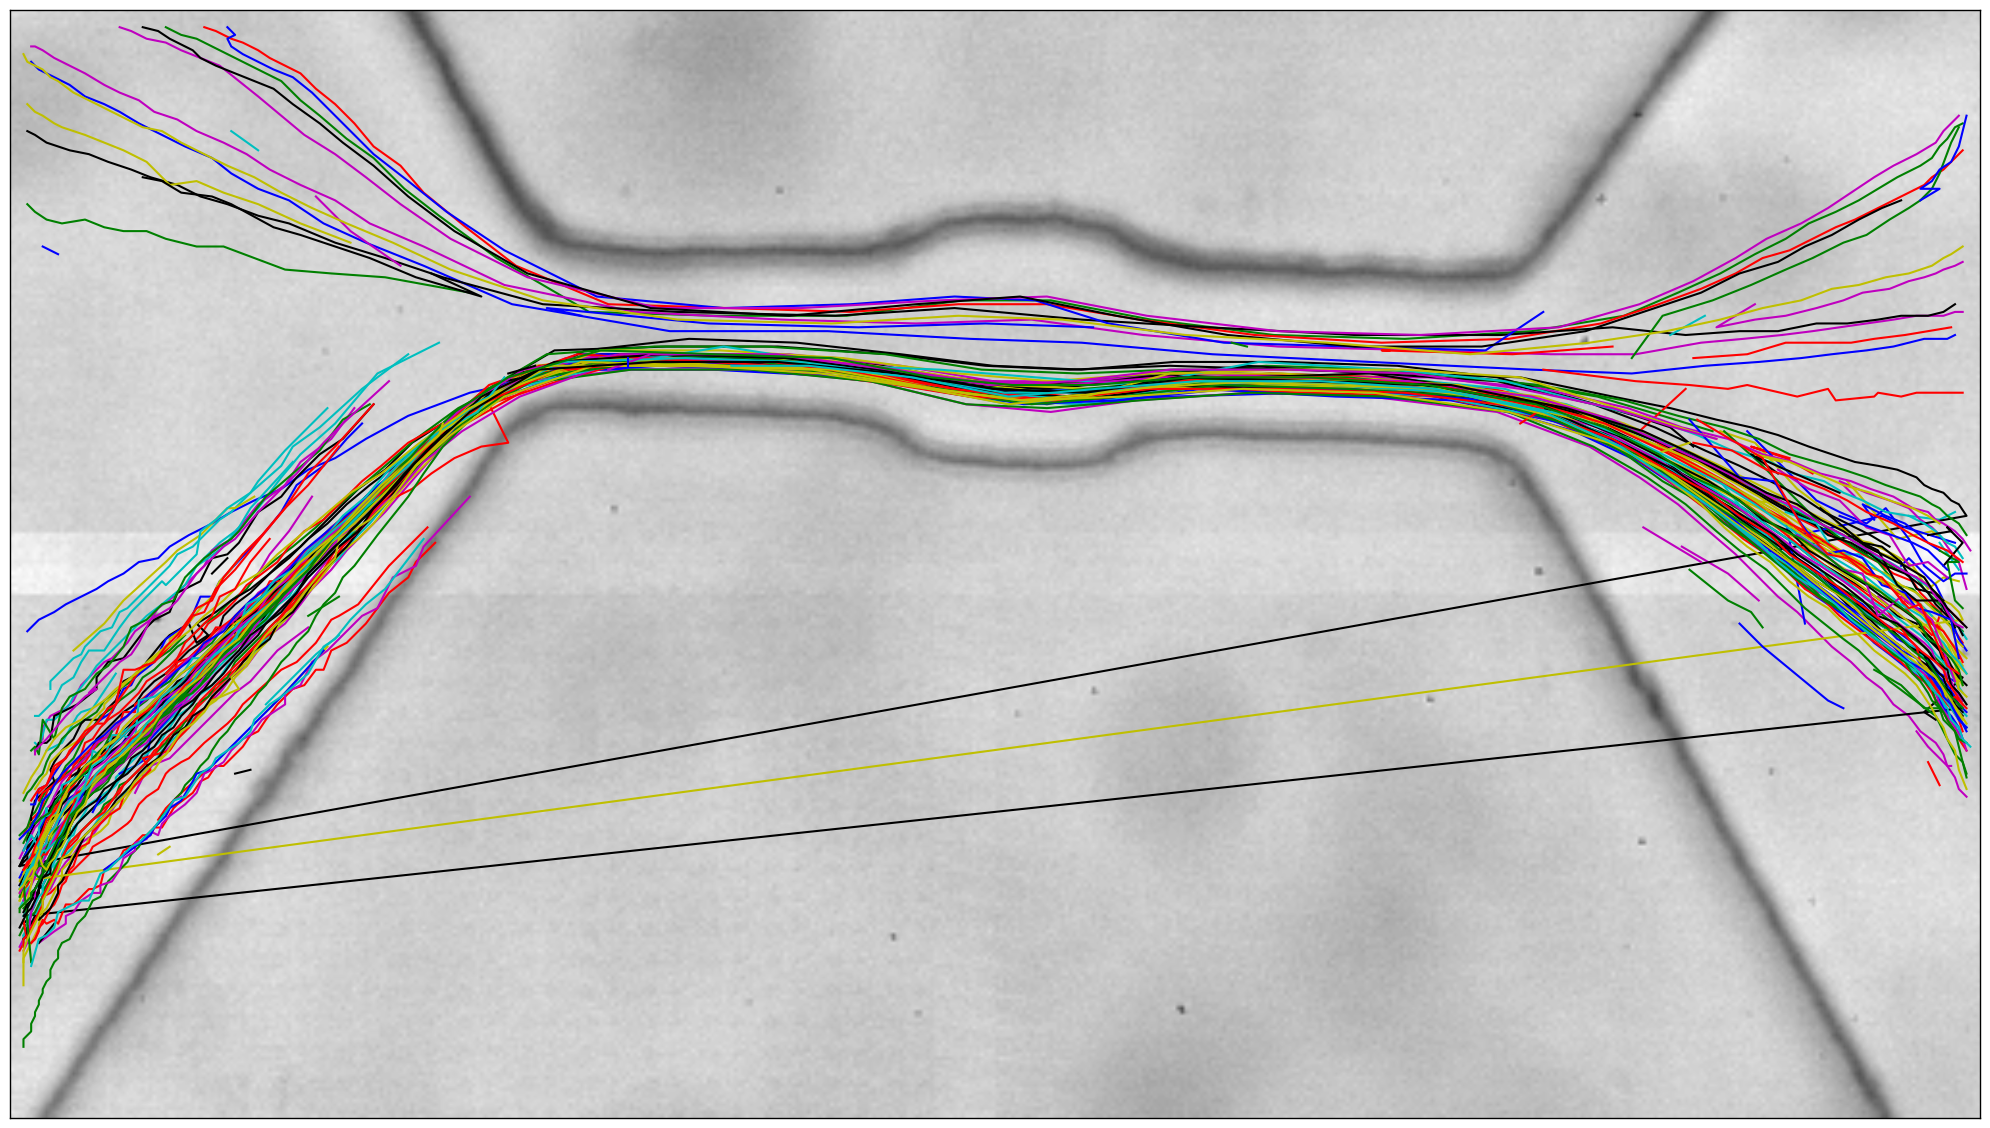

In [61]:
for event in events:
    #print len(event._detections)
    pass
    
fig = plt.figure(figsize = (20,12))

#colors = cm.rainbow()

#gs = gs.GridSpec(2, 2)

for i, event in enumerate(events[:]):
    px = []
    py = []
    for detection in event._detections:
        px.append(detection._px)
        py.append(detection._py)
    plt.plot(px, py, lw = 1.5)

plt.imshow(template_frame, alpha=0.8, cmap = 'gray', origin = 'lower')
plt.xticks([])
plt.yticks([])

fig.tight_layout()

#plt.savefig('/home/preston/Desktop/Science/Research/cancer_cells/10-5-2016_10um_0_10000fps.png', dpi = 300)

plt.show()

##### Save events

In [32]:
print output_file_path

/home/prestonh/Desktop/Research/cancer_cells/data/3-1-2017/multipillar_0/oi/bin/test_camera_0_events.json


In [62]:
oi_file.save_oi_events_json(output_file_path, raw_events)

In [44]:
events = copy.deepcopy(raw_events)

In [ ]:
file_directory_bvi = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/bvi/'
file_directory_gallery = file_directory_bvi.split('bvi')[0] + 'events/oi_gallery/'
if not os.path.exists(file_directory_gallery):
    os.makedirs(file_directory_gallery)
    
gallery_base_name = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/bvi/HCT-116_pr0005_0000.bvi'
gallery_base_name = gallery_base_name.split('bvi')[-2].replace('/', '').replace('.','')+'_'

In [ ]:
def create_event_gallery(event_num):
    px_list = []
    py_list = []
    
    directory = file_directory_bvi.split('/')[0]+'/'
    
    for i, det in enumerate(events[event_num]._detections[:1]):
        px_list.append(det._px)
        py_list.append(det._py)
        fig = plt.figure(figsize = ((12,6)))
        plt.imshow(oi_file.get_frame_bvi(file_path_bvi, det._tf, 256, 512), alpha=0.5, cmap = 'gray', origin = 'lower')
        
        plt.plot(px_list, py_list)
        
        plt.savefig(file_directory_gallery + gallery_base_name + str(event_num) + '-' + str(i) + '.png' )

# Find particle edges

In [ ]:
template_index = 0
event_index = 4



template_frame = vid.get_frame(0)
template_frame = oi.change_frame_contrast(template_frame, alpha = alpha, beta = beta)
#template_frame = cv2.GaussianBlur(template_frame, (5,5), 0)

indices = [det._tf for det in events[event_index]._detections]
frames = [vid.get_frame(index) for index in indices]
frames = [oi.change_frame_contrast(frame, alpha = alpha, beta = beta) for frame in frames]
frames = [cv2.GaussianBlur(frame, (5,5), 0) for frame in frames]

neg_frames = [abs(frame - template_frame) for frame in frames]

clusters = [det._pixels for det in events[event_index]._detections]

In [ ]:
plt.imshow(frames[8], cmap = 'gray', vmin = 0, vmax = 1)
plt.show()

plt.imshow(template_frame, cmap = 'gray', vmin = 0, vmax = 1)
plt.show()

# Canny method
- image preprocessing
- convolve image with Sobel kernels to find gradients; gradient direction is rounded to one of four angles
- non-maximum suppression: (thinning the edges)
- Hysteresis thresholding: check to see if maximum gradient in a detected edge exceeds a max value, or falls below a min value

In [ ]:
delta = 10

for i, frame in enumerate(frames):
    #frame_temp = cv2.GaussianBlur(frames[i] - template_frame, (5,5), 0)
    print i
    frame_temp = (frames[i] - template_frame) + .5
    
    row0 = clusters[i][:,0].min() - delta
    row1 = clusters[i][:,0].max() + delta
    
    col0 = clusters[i][:,1].min() - delta
    col1 = clusters[i][:,1].max() + delta
    
    if row0 < 0:
        row0 = 0
    if col0 < 0:
        col0 = 0
    
    print row0, row1, col0, col1
    
    window = cv2.cvtColor(np.uint8(256*\
                                   frame_temp[row0:row1, col0:col1]),\
                                   cv2.COLOR_GRAY2BGR)
    
    
    edges = cv2.Canny(window, 50, 200)
    #edges = cv2.Canny(window, 5, 175)
    
    if edges != None:
        #plt.imshow(window, cmap = 'gray', vmin = 0, vmax = 1)
        plt.imshow(edges, zorder = 100, cmap = 'gray', interpolation = 'none')
        #plt.imshow(frame_temp, cmap = 'gray', vmin = 0, vmax = 1)
    plt.show()
    
    plt.imshow(frame, cmap = 'gray', vmin = 0, vmax = 1)
    plt.show()

In [ ]:
print edges

In [ ]:
new_template_frame = cv2.cvtColor(np.uint8(256*template_frame), cv2.COLOR_GRAY2BGR)
new_frame = cv2.cvtColor(np.uint8(256*frame), cv2.COLOR_GRAY2BGR)

In [ ]:
edges_0 = cv2.Canny(new_template_frame, 15, 20)
edges_1 = cv2.Canny(new_frame, 15, 60)
edges_2 = edges_1 - edges_0

In [ ]:
plt.imshow(edges_0)
plt.show()

plt.imshow(edges_1)
plt.show()

fig = plt.figure(figsize = (16,10))
plt.imshow(edges_2)
plt.show()

In [ ]:
index = 10
frame = frames[index]
plt.imshow(frame, cmap = 'gray', vmin = 0, vmax = 1)
plt.show()

In [ ]:
cluster = clusters[index]
pixels = frame[np.min(cluster[:,0]-5):np.max(cluster[:,0]+5), np.min(cluster[:,1]-5):np.max(cluster[:,1]+5)]
plt.imshow(pixels, cmap = 'gray', vmin = 0, vmax = 1)
plt.show()

In [ ]:
grad_mags = np.zeros((pixels.shape[0], pixels.shape[1]))
grad_direcs = np.zeros((pixels.shape[0], pixels.shape[1]))
for pix in pixels:
    for i in range()
    

In [ ]:
fig = plt.figure(figsize = (10,6))
for coord in coords:
    plt.scatter(coord[1], coord[0])
plt.imshow(frame, cmap = 'gray', vmin = 0, vmax = 1)
plt.show()

# 1-D derivative method

In [ ]:
reload(rp)

In [ ]:
offset = -1

boundaries_x = [np.empty((0,2), dtype = int) for i in range(len(clusters))]
boundaries_y = [np.empty((0,2), dtype = int) for i in range(len(clusters))]


for i in range(len(clusters)):
    start_row = np.min(clusters[i][:,0])-offset
    stop_row = np.max(clusters[i][:,0])+offset
    
    start_column = np.min(clusters[i][:,1])
    stop_column = np.max(clusters[i][:,1])
    
    for j in range(start_row, stop_row+1):
        data = gaussian_filter(neg_frames[i][j, start_column:stop_column+1], sigma = 1)
        maxima, minima = rp.get_maxima_minima(data, num_maxima = 0, num_minima = 2, return_by = 'low')

        if len(minima) == 2:
            
            
            boundaries_x[i] = np.vstack((boundaries_x[i], [start_column + minima[0], j]))
            boundaries_x[i] = np.vstack((boundaries_x[i], [start_column + minima[1], j]))
            
            
    start_row = np.min(clusters[i][:,0])
    stop_row = np.max(clusters[i][:,0])
    
    start_column = np.min(clusters[i][:,1])-offset
    stop_column = np.max(clusters[i][:,1])+offset
    
    for j in range(start_column, stop_column+1):
        data = gaussian_filter(neg_frames[i][start_row:stop_row+1, j], sigma = 1)
        maxima, minima = rp.get_maxima_minima(data, num_maxima = 0, num_minima = 2, return_by = 'low')

        if len(minima) == 2:
            boundaries_y[i] = np.vstack((boundaries_y[i], [j, start_row + minima[0]]))
            boundaries_y[i] = np.vstack((boundaries_y[i], [j, start_row + minima[1]]))

In [ ]:
boundaries = []
for i in range(len(boundaries_x)):
    boundaries.append(np.vstack((boundaries_x[i], boundaries_y[i])))

### Calculate centroids

In [ ]:
centroids = [np.zeros((2), dtype = float) for i in range(len(frames))]
for i in range(len(frames)):
    centroids[i][0] = np.mean(boundaries[i][:,0])
    centroids[i][1] = np.mean(boundaries[i][:,1])


In [ ]:
for i in range(len(frames)):
    index = i

    fig = plt.figure(figsize = (18, 12))
    plt.imshow(neg_frames[index], vmin = 0, vmax = 1, cmap = 'gray')
    try:
        plt.scatter(centroids[i][0], centroids[i][1])
        plt.scatter(boundaries[index][:,0], boundaries[index][:,1])
    except:
        pass
    plt.show()

# Remove outliers

In [ ]:
max_dist = 2
remove_list = []
for i in range(len(frames)):
    for j in range(boundaries[i].shape[0]):
        distances = ((boundaries[i][j,0]-boundaries[i][[k for k in range(boundaries[i].shape[0]) if k != j],0])**2.+\
        (boundaries[i][j,1]-boundaries[i][[k for k in range(boundaries[i].shape[0]) if k != j],1])**2.)**.5
        min_dist = np.min(distances)
        
        if min_dist > max_dist:
            remove_list.append(j)
            
    boundaries[i] = boundaries[i][[k for k in range(boundaries[i].shape[0]) if k not in remove_list],:]

# Plot radius vs theta

In [ ]:
for i in range(len(frames)):
    thetas = []
    rs = []
    for j in range(boundaries[i].shape[0]):
        dx = boundaries[i][j,0] - centroids[i][0]
        dy = boundaries[i][j,1] - centroids[i][1]
        theta = np.arctan2(dy, dx)
        if theta < 0:
            theta += 2*3.14159
        theta = theta*180/3.14159
        thetas.append(theta)
                
        rs.append((dx**2.+dy**2.)**.5)
        
    fig = plt.figure(figsize = (18,12))
    plt.imshow(frames[i], cmap = 'gray', vmin = 0, vmax = 1)
    plt.scatter(centroids[i][0], centroids[i][1])
    plt.scatter(boundaries[i][:,0], boundaries[i][:,1])
    plt.show()
    plt.scatter(thetas, rs)
    plt.ylim(0, max(rs))
    plt.xticks([0, 90, 180, 270, 360])
    plt.grid()
    plt.show()

# Plot aspect ratio

In [ ]:
aspects = []
for i in range(len(frames)):
    print np.max(boundaries[i][:,0]), np.min(boundaries[i][:,0]), np.max(boundaries[i][:,1]), np.min(boundaries[i][:,1])
    
    aspects.append(1.*(np.max(boundaries[i][:,0])-np.min(boundaries[i][:,0]))/(np.max(boundaries[i][:,1])-np.min(boundaries[i][:,1])))

In [ ]:
plt.scatter([i for i in range(len(aspects))], aspects)
plt.grid()
plt.show()

In [ ]:
for i, frame in enumerate(frames):
    plt.imshow(frame, cmap = 'gray', vmin = 0, vmax = 1, origin = 'lower')
    plt.xticks([])
    plt.yticks([])
    plt.savefig('/home/preston/Desktop/Science/Research/cancer_cells/nsf_proposal/cell_deformations/'+str(i)+'.png', dpi = 300)
    plt.show()

In [ ]:
print 56/64.
print 65/58.
print 65/61.
print 59/64.
print 59/56.
print 58/70.